In [2]:
import sys
sys.path.append('/home/wangs/rs/lib')
'''sys.path.append('/home/wangs/rs/lwm/lib')'''
import ff
import pandas as pd
import numpy as np

# 1. 前言
传统日内换手率因子 itaTurn20，与传统反转因子 ret20 一样，其构造方式非常简单，
即每月月底计算每只股票过去 20 个交易日的换手率平均值，并做市值中性化处理。

In [3]:
# 获取收益率和换手率数据
# 日内收益率：open to close
# 隔夜收益率：close to open
close=ff.read('close')*ff.read('post')
open=ff.read('open')*ff.read('post')
pct_chg_in=(close-open)/open
pct_chg_bt=(open-close.shift(1,axis=1))/(close.shift(1,axis=1))
pct_chg=(close-close.shift(1,axis=1))/(close.shift(1,axis=1))
# 每日换手率
t_rate=ff.read('turnover_rate')

In [4]:
dates=list(t_rate.loc[:,'20200210':'20230410'].columns)

In [22]:
# 传统日内换手率因子itaTurn20
def itaTurn20(date):
    result={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_rate=t_rate.iloc[:,(n_date-20):n_date]#日内换手率
    for code in t_rate.index:
        data=data_rate.loc[code,:]
        result[code]=data.mean()
    return result

In [24]:
from multiprocessing import Pool
from tqdm import tqdm
#tqdm加在可迭代对象外，可以查看运行进程
with Pool(24) as p:
    res_lst_itaTurn20 = list(tqdm(p.imap(itaTurn20, dates), total=len(dates)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [00:18<00:00, 42.10it/s]


In [25]:
itaTurn=pd.DataFrame(res_lst_itaTurn20,index=dates).T

In [26]:
itaTurn.loc['000001.SZ',:]

20200210    0.537765
20200211    0.543520
20200212    0.557575
20200213    0.566380
20200214    0.570640
              ...   
20230403    0.523770
20230404    0.505340
20230406    0.489060
20230407    0.475315
20230410    0.446250
Name: 000001.SZ, Length: 771, dtype: float64

In [14]:

# 做市场中性化处理
# *推荐使用
# 消除市值与行业因素的影响（中性化）
import extend
mv=ff.read('total_mv')
itaTurn20 = extend.spread_reg(itaTurn, mv.loc[itaTurn.index,itaTurn.columns],ind=False) # ind=True为同时进行市值与行业中性化

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


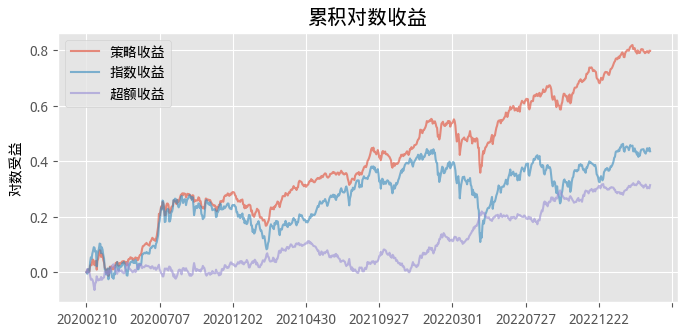

,指数收益,超额收益,策略收益
年化收益率,0.141,0.102,0.259
年化波动率,0.211,0.106,0.155
夏普率,0.669,0.960,1.663
最大回撤,-0.335,-0.115,-0.194
收益回撤比,0.422,0.886,1.334
胜率,0.541,0.506,0.580
盈亏比,0.949,1.138,0.970


In [16]:
# 回测
import matplotlib as mpl
mpl.rc("font", family='Droid Sans Fallback', weight="bold")
h = ff.run((itaTurn20*ff.filter0).loc[:,dates], positions = 100, period = 1, fees = 0) 

IC,ICIR，以及rankIC和rankICIR计算

IC，两个变量分别是因子值、下期收益率（皮尔森相关系数）
rankIC，斯皮尔曼秩相关系数

In [175]:
pct_chg_nex=pct_chg.shift(-1,axis=1).loc[itaTurn20.index,itaTurn20.columns]
def get_IC(para):
    result={}
    date,factor=para
    pct_chg_nex_date=pct_chg_nex.loc[:,date]
    result[date]=pct_chg_nex_date.corr(factor) 
    return result

In [176]:
itaTurn20_list = [(col, itaTurn20[col]) for col in itaTurn20.columns]
# IC
# 因子值itaTurn20
#tqdm加在可迭代对象外，可以查看运行进程
with Pool(24) as p:
    res_lst_itaTurn20_IC = list(tqdm(p.imap(get_IC, itaTurn20_list), total=len(itaTurn20_list)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 795/795 [00:00<00:00, 1366.42it/s]


In [177]:
# IC均值常用于判断因子的显著性。一般IC均值的绝对值>0.03（标准高一些一般会是0.05），则认为该因子较为显著。（也有说法称有效性）
itaTurn20_IC=pd.Series({list(i.keys())[0]: list(i.values())[0] for i in res_lst_itaTurn20_IC}).T
itaTurn20_IC.mean()
# IR
itaTurn20_IR=itaTurn20_IC.mean()/itaTurn20_IC.std()

# 2. 前情提要

##  2.1. 成交量对动量因子的修正：日内切割

当日日内换手率
从低到高排序（日内换手率=当日总换手率-开盘集合竞价换手率）
利用日内换手率对日内
收益率进行切割

In [8]:
# 获取开盘集合竞价换手率第一分钟换手率
# 总股本
float_share=(ff.read('float_share')*ff.filter0).dropna(how='all',axis=0)
def get_t_rate_open(code):
    result={}
    data=ff.read_min(code)
    # 首先转化为时间数据
    data.index=pd.to_datetime(data.index)
    # 提取第一分钟数据
    data=data.groupby(data.index.date).first()['volume']
    code_share=float_share.loc[code,:]
    # index转换
    data_date=data.index
    data.index=pd.to_datetime(data_date).strftime('%Y%m%d')
    # 开盘集合竞价换手率=第一分钟换手率/总换手率,除100
    result[code]=(data/code_share)/100
    return result

In [9]:
codes=float_share.index# 有的股票在ff.read_min中读不出来
with Pool(24) as p:
    res_lst_get_t_rate_open = list(tqdm(p.imap(get_t_rate_open, codes), total=len(codes)))
    #注意：imap只能传入一个参数，如果有多个参数需要传入的话可以用元组作为参数，在函数中再对元组进行拆包

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:32<00:00, 154.13it/s]


In [10]:
# 开盘集合竞价换手率
t_rate_open=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_get_t_rate_open}).T
# 日内换手率=当日总换手率'turnover_rate'-开盘集合竞价换手率第一分钟换手率
t_rate_in=t_rate-t_rate_open
# 对t_rate_open大小进行变换
t_rate_open=t_rate-t_rate_in
# t_rate_open为隔夜换手率

In [14]:
# 日内切割函数，输出5个日内因子;日内换手率对日内收益率进行切割;factor1最小(低换手)
def Intraday(date):
    result_1={}
    result_2={}
    result_3={}
    result_4={}
    result_5={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_pct=pct_chg_in.iloc[:,(n_date-20):n_date] #日内收益率
    data_rate=t_rate_in.iloc[:,(n_date-20):n_date] # 日内换手率
    for code in t_rate.index:
        data=pd.concat([data_pct.loc[code,:],data_rate.loc[code,:]],axis=1)
        data.columns=['pct_chg',"t_rate"]
        data=data.sort_values('t_rate')
        result_1[code]=data.iloc[0:4,0].mean()
        result_2[code]=data.iloc[4:8,0].mean()
        result_3[code]=data.iloc[8:12,0].mean()
        result_4[code]=data.iloc[12:16,0].mean()
        result_5[code]=data.iloc[16:20,0].mean()
    return result_1,result_2,result_3,result_4,result_5

In [15]:
with Pool(24) as p:
    res_lst_Intraday = list(tqdm(p.imap(Intraday, dates), total=len(dates)))
    #注意：imap只能传入一个参数，如果有多个参数需要传入的话可以用元组作为参数，在函数中再对元组进行拆包

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 796/796 [03:49<00:00,  3.47it/s]


In [154]:
# 解包 res_lst 中的值到 res_lst1 和 res_lst2
res_lst1,res_lst2, res_lst3,res_lst4, res_lst5 = zip(*res_lst_Intraday)
res_lst_data=[res_lst1,res_lst2, res_lst3,res_lst4, res_lst5]
factor={}
for i in range(5):
    nfactor=pd.DataFrame(data=res_lst_data[i])
    nfactor.index=dates
    nfactor=nfactor.T
    factor[f'factor_{i}']=nfactor

In [184]:
factor_IR['itaTurn20']=itaTurn20_IR

In [159]:
factor_IR={}
factor_IR['itaTurn20']=itaTurn20_IR
pct_chg_nex=pct_chg.shift(-1,axis=1).loc[itaTurn20.index,itaTurn20.columns]
for i in range(5):
    factor_list = [(col, factor[f'factor_{i}'][col]) for col in factor[f'factor_{i}'].columns]
    # IC
    # 因子值itaTurn20
    #tqdm加在可迭代对象外，可以查看运行进程
    with Pool(24) as p:
        res_lst_IC = list(tqdm(p.imap(get_IC, factor_list), total=len(factor_list)))
        # IR
    factor_IC=pd.Series({list(i.keys())[0]: list(i.values())[0] for i in res_lst_IC}).T
    factor_IR[f'factor_{i}']=factor_IC.mean()/factor_IC.std()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 796/796 [00:01<00:00, 664.59it/s]


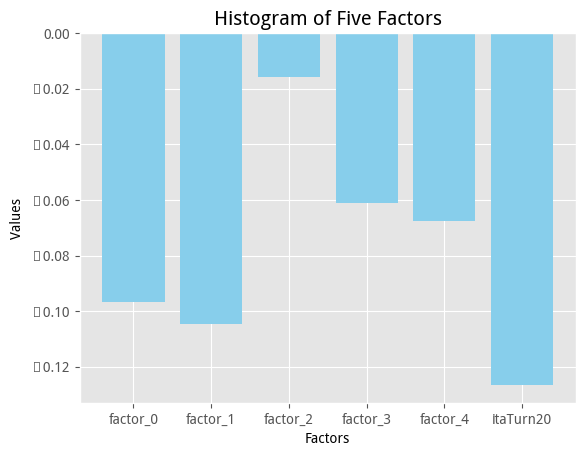

In [185]:
import matplotlib.pyplot as plt
# 绘制直方图
plt.bar(factor_IR.keys(), factor_IR.values(), color='skyblue')
plt.title('Histogram of Five Factors')
plt.xlabel('Factors')
plt.ylabel('Values')
plt.show()

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


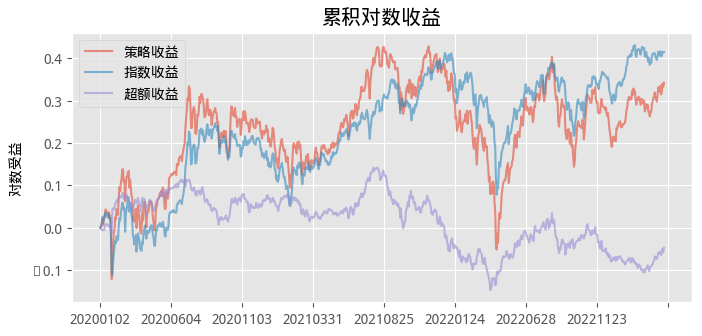

,指数收益,超额收益,策略收益
年化收益率,0.130,-0.015,0.108
年化波动率,0.217,0.125,0.281
夏普率,0.600,-0.119,0.383
最大回撤,-0.335,-0.289,-0.480
收益回撤比,0.389,-0.051,0.224
胜率,0.540,0.489,0.536
盈亏比,0.942,1.023,0.919


In [17]:
h = ff.run((factor['factor_0']*ff.filter0).loc[:,dates], positions = 100, period = 1, fees = 0) 

## 2.2. 成交量对动量因子的修正：隔夜切割

取股票过去 20 个交易日的隔夜收益率，按照昨日换手率（选择的是昨日日内换手率）从低到高
排序；

In [19]:
# 隔夜切割函数;昨日换手率对隔日收益率进行切割
t_rate_yes=t_rate_in.shift(1,axis=1)
def Outday(date):
    result_1={}
    result_2={}
    result_3={}
    result_4={}
    result_5={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_pct=pct_chg_bt.iloc[:,(n_date-20):n_date]
    data_rate=t_rate_yes.iloc[:,(n_date-20):n_date]
    for code in t_rate.index:
        data=pd.concat([data_pct.loc[code,:],data_rate.loc[code,:]],axis=1)
        data.columns=['pct_chg',"t_rate"]
        data=data.sort_values('t_rate')
        result_1[code]=data.iloc[0:4,0].mean()
        result_2[code]=data.iloc[4:8,0].mean()
        result_3[code]=data.iloc[8:12,0].mean()
        result_4[code]=data.iloc[12:16,0].mean()
        result_5[code]=data.iloc[16:20,0].mean()
    return result_1,result_2,result_3,result_4,result_5

In [20]:
with Pool(24) as p:
    res_lst_Outday = list(tqdm(p.imap(Outday, dates), total=len(dates)))
    #注意：imap只能传入一个参数，如果有多个参数需要传入的话可以用元组作为参数，在函数中再对元组进行拆包

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 796/796 [03:47<00:00,  3.50it/s]


In [317]:
# 解包 res_lst 中的值到 res_lst1 和 res_lst2
res_lst1,res_lst2, res_lst3,res_lst4, res_lst5 = zip(*res_lst_Outday)
res_lst_data=[res_lst1,res_lst2, res_lst3,res_lst4, res_lst5]
factor={}
for i in range(5):
    nfactor=pd.DataFrame(data=res_lst_data[i])
    nfactor.index=dates
    nfactor=nfactor.T
    factor[f'factor_{i}']=nfactor

In [190]:
pct_chg_nex

,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,20200116,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,-0.006403,0.004687,-0.028571,0.007803,-0.005956,0.017975,-0.013537,-0.014320,-0.011501,0.003674,...,0.011173,-0.001579,-0.005534,0.003180,0.004754,-0.011041,-0.004785,0.006410,0.010350,0.018913
000002.SZ,-0.016849,0.007934,-0.002519,0.016414,-0.022981,0.006993,-0.009154,-0.028672,0.001312,-0.002293,...,0.011155,-0.016872,-0.007261,0.051862,-0.007585,0.021656,0.000623,-0.012461,-0.002524,0.007590
000004.SZ,-0.026846,0.016092,-0.014480,0.024793,0.000448,0.031348,-0.001303,-0.019565,-0.003991,-0.009795,...,0.024242,-0.037475,-0.011270,0.032124,-0.012048,0.006098,0.016162,0.005964,-0.007905,0.023904
000005.SZ,0.000000,0.015873,-0.015625,0.019048,-0.012461,-0.003155,0.012658,-0.009375,-0.012618,0.000000,...,0.011299,-0.011173,-0.011299,0.005714,-0.005682,-0.005714,0.005747,-0.005714,-0.005747,0.000000
000006.SZ,-0.003650,0.005495,-0.018215,0.014842,-0.001828,0.012821,-0.005425,-0.005455,-0.014625,-0.007421,...,0.007874,-0.021484,0.001996,0.027888,-0.025194,0.027833,-0.001934,0.000000,-0.009690,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003531,0.005996,0.011921,0.017403,0.007895,-0.001305,-0.000261,0.004969,-0.004424,0.023262
688800.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000118,-0.039778,0.036263,0.035231,0.017303,-0.076256,-0.015730,-0.015114,0.037736,0.002303
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.023506,-0.028069,-0.025963,-0.002396,0.009307,-0.007733,-0.004796,-0.010241,0.009130,0.004825
688981.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.089204,0.038109,0.042534,0.014051,0.001669,-0.026167,0.014890,-0.021922,0.073448,0.011886


In [191]:
factor_IR={}
factor_IR['itaTurn20']=itaTurn20_IR
pct_chg_nex=pct_chg.shift(-1,axis=1).loc[factor['factor_0'].index,factor['factor_0'].columns]
for i in range(5):
    factor_list = [(col, factor[f'factor_{i}'][col]) for col in factor[f'factor_{i}'].columns]
    # IC
    # 因子值itaTurn20
    #tqdm加在可迭代对象外，可以查看运行进程
    with Pool(24) as p:
        res_lst_IC = list(tqdm(p.imap(get_IC, factor_list), total=len(factor_list)))
        # IR
    factor_IC=pd.Series({list(i.keys())[0]: list(i.values())[0] for i in res_lst_IC}).T
    factor_IR[f'factor_{i}']=factor_IC.mean()/factor_IC.std()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 796/796 [00:00<00:00, 952.69it/s]


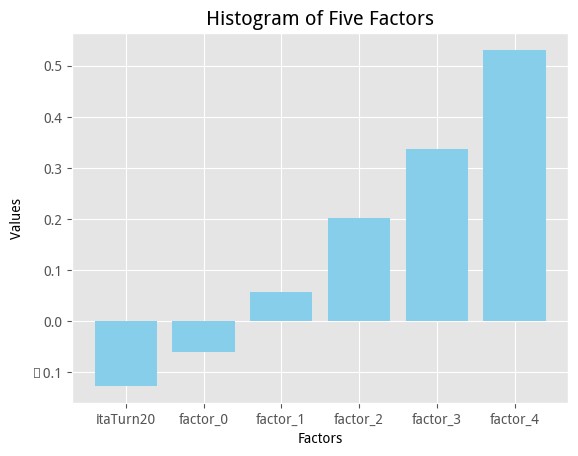

In [192]:
# 绘制直方图
plt.bar(factor_IR.keys(), factor_IR.values(), color='skyblue')
plt.title('Histogram of Five Factors')
plt.xlabel('Factors')
plt.ylabel('Values')
plt.show()

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


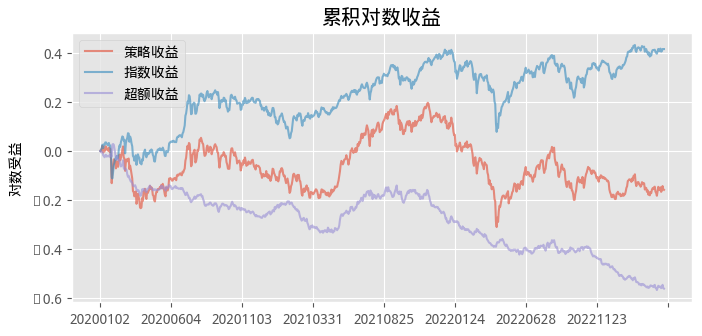

,指数收益,超额收益,策略收益
年化收益率,0.130,-0.176,-0.050
年化波动率,0.217,0.114,0.261
夏普率,0.600,-1.551,-0.190
最大回撤,-0.335,-0.595,-0.506
收益回撤比,0.389,-0.296,-0.098
胜率,0.540,0.450,0.518
盈亏比,0.942,0.944,0.901


In [318]:
h = ff.run(-(factor['factor_4']*ff.filter0).loc[:,dates], positions = 100, period = 1, fees = 0) 

# 3. 换手率的逻辑：异质信念

## 3.1. 投资的分歧：异质信念（Heterogeneous Belief）

异质信念:股价系统地被高估,不同投资者之间的预期是不同的（异质信念）----换手率因子

流动性溢价理论：低异质信念股票票的价格上涨往往与换手率的提升相对应，在价格上涨的日子里，换手率也会从低
变成高位，而不是保持低换手

## 3.2. 换手率对异质信念的识别：日内收益率的辅助

当日
日内收益率对日内换手率做切;排除缺乏流动性的可能。割

In [21]:
# 当日日内收益率对日内换手率做切割
# 日内切割函数，输出5个日内因子
def pct_to_rate(date):
    result_1={}
    result_2={}
    result_3={}
    result_4={}
    result_5={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_pct=pct_chg_in.iloc[:,(n_date-20):n_date]
    data_rate=t_rate_in.iloc[:,(n_date-20):n_date]
    for code in t_rate.index:
        data=pd.concat([data_pct.loc[code,:],data_rate.loc[code,:]],axis=1)
        data.columns=['pct_chg',"t_rate"]
        data=data.sort_values('pct_chg')
        result_1[code]=data.iloc[0:4,1].mean()
        result_2[code]=data.iloc[4:8,1].mean()
        result_3[code]=data.iloc[8:12,1].mean()
        result_4[code]=data.iloc[12:16,1].mean()
        result_5[code]=data.iloc[16:20,1].mean()
    return result_1,result_2,result_3,result_4,result_5

In [22]:
with Pool(24) as p:
    res_lst_pct_to_rate = list(tqdm(p.imap(pct_to_rate, dates), total=len(dates)))
    #注意：imap只能传入一个参数，如果有多个参数需要传入的话可以用元组作为参数，在函数中再对元组进行拆包

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [04:26<00:00,  2.90it/s]


In [24]:
# 解包 res_lst 中的值到 res_lst1 和 res_lst2
res_lst1,res_lst2, res_lst3,res_lst4, res_lst5 = zip(*res_lst_pct_to_rate)
res_lst_data=[res_lst1,res_lst2, res_lst3,res_lst4, res_lst5]
factor={}
for i in range(5):
    nfactor=pd.DataFrame(data=res_lst_data[i])
    nfactor.index=dates
    nfactor=nfactor.T
    factor[f'factor_{i}']=nfactor

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


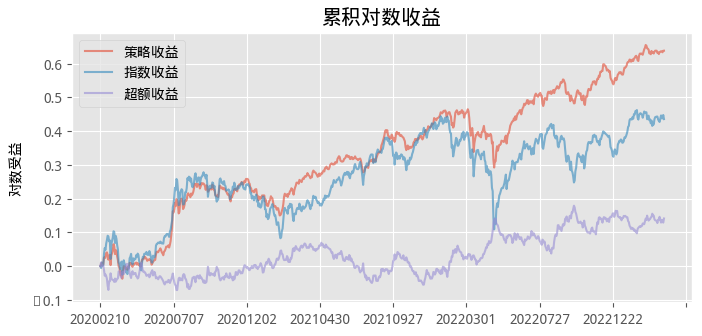

,指数收益,超额收益,策略收益
年化收益率,0.141,0.046,0.207
年化波动率,0.211,0.125,0.141
夏普率,0.669,0.367,1.470
最大回撤,-0.335,-0.124,-0.173
收益回撤比,0.422,0.368,1.198
胜率,0.541,0.482,0.551
盈亏比,0.949,1.135,1.053


In [25]:
h = ff.run((factor['factor_4']*ff.filter0).loc[:,dates], positions = 100, period = 1, fees = 0) 

## 3.3. 窥探未来信息：低频策略的未来信息使用

日内收益率并不是一把完美的切割刀

信息不对称，也会造成判断的“异质”。

## 3.4. 换手率对异质信念的识别：次日隔夜收益率的辅助
利用次日隔夜收
益率对日内换手率做切割：

In [26]:
# 换手率对异质信念的识别：次日隔夜收益率的辅助
# 次日隔夜收益率对日内换手率做切割
pct_chg_bt_nex=pct_chg_bt.shift(-1,axis=1)
def pctnex_to_rate(date):
    result_1={}
    result_2={}
    result_3={}
    result_4={}
    result_5={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_pct=pct_chg_bt.iloc[:,(n_date-20):n_date]
    data_rate=t_rate_in.iloc[:,(n_date-20):n_date]
    for code in t_rate.index:
        data=pd.concat([data_pct.loc[code,:],data_rate.loc[code,:]],axis=1)
        data.columns=['pct_chg',"t_rate"]
        data=data.sort_values('pct_chg')
        result_1[code]=data.iloc[0:4,1].mean()
        result_2[code]=data.iloc[4:8,1].mean()
        result_3[code]=data.iloc[8:12,1].mean()
        result_4[code]=data.iloc[12:16,1].mean()
        result_5[code]=data.iloc[16:20,1].mean()
    return result_1,result_2,result_3,result_4,result_5

In [27]:
with Pool(24) as p:
    res_lst_pctnex_to_rate = list(tqdm(p.imap(pctnex_to_rate, dates), total=len(dates)))
    #注意：imap只能传入一个参数，如果有多个参数需要传入的话可以用元组作为参数，在函数中再对元组进行拆包

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [04:20<00:00,  2.96it/s]


In [29]:
# 解包 res_lst 中的值到 res_lst1 和 res_lst2
res_lst1,res_lst2, res_lst3,res_lst4, res_lst5 = zip(*res_lst_pctnex_to_rate)
res_lst_data=[res_lst1,res_lst2, res_lst3,res_lst4, res_lst5]
factor={}
for i in range(5):
    nfactor=pd.DataFrame(data=res_lst_data[i])
    nfactor.index=dates
    nfactor=nfactor.T
    factor[f'factor_{i}']=nfactor

In [388]:
factor['factor_0'].loc[:,dates].head()

,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,...,20230330,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413
000001.SZ,0.461284,0.517029,0.517029,0.470622,0.470622,0.492273,0.492273,0.492273,0.492273,0.492273,...,0.567384,0.567384,0.567384,0.567384,0.567384,0.567384,0.432620,0.432620,0.408714,0.424068
000002.SZ,0.862181,0.846335,0.846335,0.846335,0.846335,0.931640,0.931640,0.931640,0.956400,0.956400,...,0.635085,0.635085,0.635085,0.635085,0.635085,0.635085,1.065002,1.111984,1.111984,1.203254
000004.SZ,2.127366,2.127366,2.127366,2.127366,2.127366,2.286291,2.286291,2.286291,2.286291,2.286291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,0.663422,0.663422,0.854655,0.854655,0.854655,0.854655,0.854655,0.854655,0.854655,0.854655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,0.741776,0.741776,0.646659,0.646659,0.646659,0.646659,0.646659,0.646659,0.646659,0.646659,...,3.098831,3.098831,2.421628,2.421628,2.421628,2.421628,2.370825,1.870474,1.650310,1.650310


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


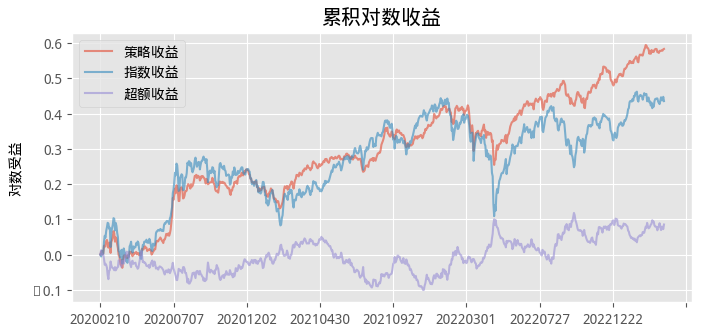

,指数收益,超额收益,策略收益
年化收益率,0.141,0.028,0.189
年化波动率,0.211,0.128,0.141
夏普率,0.669,0.216,1.346
最大回撤,-0.335,-0.151,-0.169
收益回撤比,0.422,0.183,1.120
胜率,0.541,0.468,0.541
盈亏比,0.949,1.173,1.075


In [30]:
h = ff.run((factor['factor_0'].dropna(how='all', axis=1)*ff.filter0).loc[:,'20200210':'20230410'], positions = 100, period = 1, fees = 0) 

In [345]:
# 换手率对异质信念的识别：次日隔夜收益率的辅助
# 次日隔夜收益率对日内换手率做切割
pct_chg_bt_nex=pct_chg_bt.shift(-1,axis=1)
def pctnex_to_rate_b(date):
    result_1={}
    result_2={}
    result_3={}
    result_4={}
    result_5={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_pct=pct_chg_bt_nex.iloc[:,(n_date-20):n_date]
    data_rate=t_rate_in.iloc[:,(n_date-20):n_date]
    for code in t_rate.index:
        data=pd.concat([data_pct.loc[code,:],data_rate.loc[code,:]],axis=1)
        data.columns=['pct_chg',"t_rate"]
        data=data.sort_values('pct_chg')
        result_1[code]=data.iloc[0:4,1].mean()
        result_2[code]=data.iloc[4:8,1].mean()
        result_3[code]=data.iloc[8:12,1].mean()
        result_4[code]=data.iloc[12:16,1].mean()
        result_5[code]=data.iloc[16:20,1].mean()
    return result_1,result_2,result_3,result_4,result_5

In [346]:
with Pool(24) as p:
    res_lst_pctnex_to_rate_b = list(tqdm(p.imap(pctnex_to_rate_b, dates), total=len(dates)))
    #注意：imap只能传入一个参数，如果有多个参数需要传入的话可以用元组作为参数，在函数中再对元组进行拆包

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 796/796 [04:34<00:00,  2.90it/s]


In [349]:
# 解包 res_lst 中的值到 res_lst1 和 res_lst2
res_lst1,res_lst2, res_lst3,res_lst4, res_lst5 = zip(*res_lst_pctnex_to_rate_b)
res_lst_data=[res_lst1,res_lst2, res_lst3,res_lst4, res_lst5]
factor={}
for i in range(5):
    nfactor=pd.DataFrame(data=res_lst_data[i])
    nfactor.index=dates
    nfactor=nfactor.T
    factor[f'factor_{i}']=nfactor

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


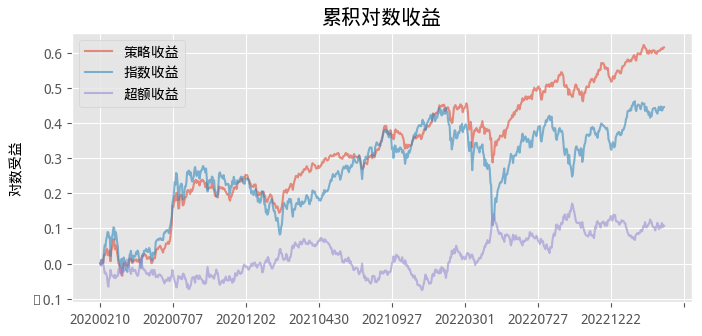

,指数收益,超额收益,策略收益
年化收益率,0.144,0.035,0.199
年化波动率,0.211,0.125,0.140
夏普率,0.684,0.277,1.424
最大回撤,-0.335,-0.148,-0.169
收益回撤比,0.430,0.234,1.178
胜率,0.541,0.481,0.547
盈亏比,0.949,1.127,1.068


In [350]:
h = ff.run((factor['factor_0']*ff.filter0).loc[:,'20200210':'20230413'], positions = 100, period = 1, fees = 0) 

当隔夜出现低收益时，主要是隔夜意外信息的推动。此时若前一个交易日保持低换手，则说明股票的信息不对称程度低，“异质信念”程度低。

## 3.5. 换手率对异质信念的识别：次日隔夜换手率的辅助
利用次日隔夜换手率
对日内换手率做切割：

In [31]:
t_rate_open_nex=t_rate_open.shift(-1,axis=1) #次日隔夜换手率

In [32]:
#用次日隔夜换手率对日内换手率做切割
#次日隔夜换手率
t_rate_open_nex=t_rate_open.shift(-1,axis=1)
def rate_opennex_to_rate(date):
    result_1={}
    result_2={}
    result_3={}
    result_4={}
    result_5={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_nex_open=t_rate_open_nex.iloc[:,(n_date-20):n_date]#次日隔夜换手率
    data_rate=t_rate_in.iloc[:,(n_date-20):n_date]
    for code in t_rate.index:
        data=pd.concat([data_nex_open.loc[code,:],data_rate.loc[code,:]],axis=1)
        data.columns=['nex_open',"t_rate"]
        data=data.sort_values('nex_open')
        result_1[code]=data.iloc[0:4,1].mean()
        result_2[code]=data.iloc[4:8,1].mean()
        result_3[code]=data.iloc[8:12,1].mean()
        result_4[code]=data.iloc[12:16,1].mean()
        result_5[code]=data.iloc[16:20,1].mean()
    return result_1,result_2,result_3,result_4,result_5

In [33]:
with Pool(24) as p:
    res_lst_rate_opennex_to_rate = list(tqdm(p.imap(rate_opennex_to_rate, dates), total=len(dates)))
    #注意：imap只能传入一个参数，如果有多个参数需要传入的话可以用元组作为参数，在函数中再对元组进行拆包

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [03:51<00:00,  3.33it/s]


In [34]:
# 解包 res_lst 中的值到 res_lst1 和 res_lst2
res_lst1,res_lst2, res_lst3,res_lst4, res_lst5 = zip(*res_lst_rate_opennex_to_rate)
res_lst_data=[res_lst1,res_lst2, res_lst3,res_lst4, res_lst5]
factor={}
for i in range(5):
    nfactor=pd.DataFrame(data=res_lst_data[i])
    nfactor.index=dates
    nfactor=nfactor.T
    factor[f'factor_{i}']=nfactor

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


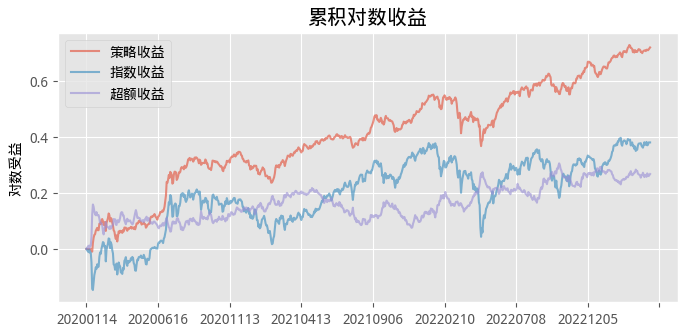

,指数收益,超额收益,策略收益
年化收益率,0.121,0.085,0.228
年化波动率,0.218,0.135,0.141
夏普率,0.554,0.628,1.619
最大回撤,-0.335,-0.142,-0.184
收益回撤比,0.360,0.596,1.239
胜率,0.539,0.480,0.551
盈亏比,0.938,1.204,1.086


In [35]:
h = ff.run((factor['factor_4']*ff.filter0).loc[:,dates], positions = 100, period = 1, fees = 0) 

## 3.6. 新的隔夜指标：次日隔夜聪明钱

In [35]:
# OvernightSmart20因子
# 隔夜收益率：pct_chg_bt；隔夜换手率：t_rate_open
def OvernightSmart(date):
    result={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_pct_bt=pct_chg_bt.iloc[:,(n_date-20):n_date]#隔夜收益率
    data_rate_open=t_rate_open.iloc[:,(n_date-20):n_date]#隔夜换手率
    for code in t_rate.index:
        data=pd.concat([data_pct_bt.loc[code,:],data_rate_open.loc[code,:]],axis=1)
        data.columns=['pct_chg_bt',"t_rate_open"]
        pct_min=data['pct_chg_bt'].min()
        pct_max=data['pct_chg_bt'].max()
        data['OvernightSmart']=((data['pct_chg_bt']-pct_min)/(pct_max-pct_min))/data["t_rate_open"]
        result[code]=data['OvernightSmart'].mean()
    return result

In [36]:
with Pool(24) as p:
    res_lst_OvernightSmart = list(tqdm(p.imap(OvernightSmart, dates), total=len(dates)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [03:16<00:00,  3.93it/s]


In [37]:
Overnight_Smart=pd.DataFrame(data=res_lst_OvernightSmart,index=dates).T

In [397]:
Overnight_Smart.loc[:,'20200206':'20230413'].head()

,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,...,20230330,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413
000001.SZ,74.005359,72.338767,73.210778,75.735757,74.590567,72.005750,70.081757,69.324100,66.391071,62.425244,...,36.947667,36.592891,36.859688,35.974207,34.487369,37.105402,37.604079,39.216721,40.567665,41.612952
000002.SZ,45.214226,45.675308,47.293058,48.508638,50.977103,51.687512,51.734403,52.498845,48.877324,47.926572,...,25.869359,27.722837,28.418721,28.205221,27.337853,21.372945,15.249464,18.491590,18.242983,18.328078
000004.SZ,31.452226,30.225045,29.641806,28.760786,25.428411,27.991720,25.413940,24.515902,18.601837,18.270190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,64.538359,65.706204,67.147727,66.514364,65.332809,69.466204,73.824689,79.060825,84.313088,82.503989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,76.870411,80.717315,81.393220,81.577395,84.183640,83.446075,82.945668,86.842690,85.480375,79.118250,...,16.661796,16.806869,19.267210,21.825396,23.976850,26.163527,26.859629,18.194238,19.637496,19.777840


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


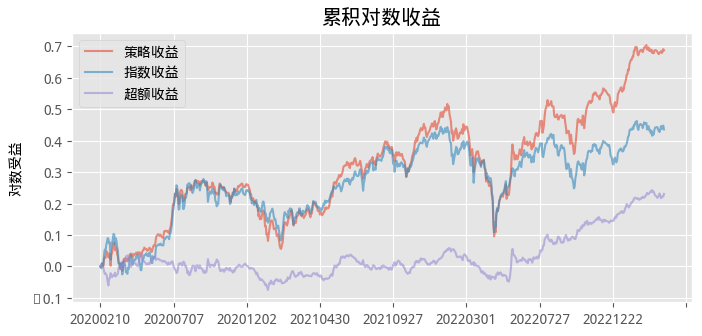

,指数收益,超额收益,策略收益
年化收益率,0.141,0.075,0.223
年化波动率,0.211,0.093,0.198
夏普率,0.669,0.800,1.123
最大回撤,-0.335,-0.113,-0.421
收益回撤比,0.422,0.660,0.529
胜率,0.541,0.498,0.550
盈亏比,0.949,1.153,0.991


In [38]:
h = ff.run(-(Overnight_Smart*ff.filter0).loc[:,dates], positions = 100, period = 1, fees = 0) 

# 4. 优中选优：换手率切割刀 CTR 因子

## 4.1. 换手率切割刀 CTR 因子（Cutlets of Turnover Rate）
取股票过去 20 个交易日的日内换手率，按照次日隔夜聪明钱从低到高排序；

In [212]:
# 换手率切割刀 CTR 因子
# 次日隔夜聪明钱对日内换手率做切割
# 把低次日隔夜聪明钱切割出的因子作为新因子
# 前一个交易日的日内换手率
t_rate_in_front=t_rate_in.shift(1,axis=1) # 昨日日内换手率
Overnight_Smart=Overnight_Smart*ff.filter0
#如“行业、市值中性化”，一般指做回归：以市值或行业向量为解释变量，因子数据为被解释变量，使用最小二乘法，正交化后的残差成为中性化后的因子数据，这样的作法可以消除行业、市值对于股票因子数据的影响。
def get_CTR_a(date):
    result_1={}
    result_2={}
    result_3={}
    result_4={}
    result_5={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_rate_in_front=t_rate_in_front.iloc[:,(n_date-20):n_date]#前一个交易日的日内换手率
    data_smart=Overnight_Smart.iloc[:,(n_date-20):n_date]
    for code in t_rate.index:
        data=pd.concat([data_rate_in_front.loc[code,:],data_smart.loc[code,:]],axis=1)
        data.columns=['data_rate_in_front','data_smart']
        data=data.sort_values('data_smart')
        result_1[code]=data.iloc[0:4,0].mean()
        result_2[code]=data.iloc[4:8,0].mean()
        result_3[code]=data.iloc[8:12,0].mean()
        result_4[code]=data.iloc[12:16,0].mean()
        result_5[code]=data.iloc[16:20,0].mean()
    return result_1,result_2,result_3,result_4,result_5

In [213]:
with Pool(24) as p:
    res_lst_get_CTR = list(tqdm(p.imap(get_CTR_a, dates), total=len(dates)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 796/796 [03:49<00:00,  3.47it/s]


In [217]:
# 解包 res_lst 中的值到 res_lst1 和 res_lst2
res_lst1,res_lst2, res_lst3,res_lst4, res_lst5 = zip(*res_lst_get_CTR)
res_lst_data=[res_lst1,res_lst2, res_lst3,res_lst4, res_lst5]
factor={}
for i in range(5):
    nfactor=pd.DataFrame(data=res_lst_data[i])
    nfactor.index=dates
    nfactor=nfactor.T
    factor[f'factor_{i}']=nfactor

In [218]:
factor_IR={}
factor_IR['itaTurn20']=itaTurn20_IR
pct_chg_nex=pct_chg.shift(-1,axis=1).loc[factor['factor_0'].index,factor['factor_0'].columns]
for i in range(5):
    factor_list = [(col, factor[f'factor_{i}'][col]) for col in factor[f'factor_{i}'].columns]
    # IC
    # 因子值itaTurn20
    #tqdm加在可迭代对象外，可以查看运行进程
    with Pool(24) as p:
        res_lst_IC = list(tqdm(p.imap(get_IC, factor_list), total=len(factor_list)))
        # IR
    factor_IC=pd.Series({list(i.keys())[0]: list(i.values())[0] for i in res_lst_IC}).T
    factor_IR[f'factor_{i}']=factor_IC.mean()/factor_IC.std()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 796/796 [00:00<00:00, 991.21it/s]


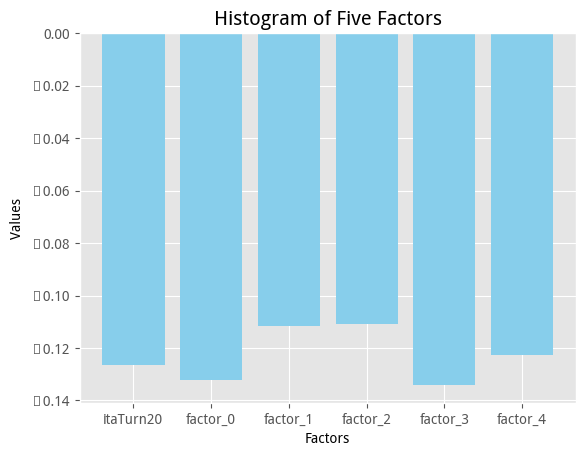

In [219]:
# 绘制直方图
plt.bar(factor_IR.keys(), factor_IR.values(), color='skyblue')
plt.title('Histogram of Five Factors')
plt.xlabel('Factors')
plt.ylabel('Values')
plt.show()

In [11]:
# 换手率切割刀 CTR 因子
# 次日隔夜聪明钱对日内换手率做切割
# 把低次日隔夜聪明钱切割出的因子作为新因子
# 前一个交易日的日内换手率
t_rate_in_front=t_rate_in.shift(1,axis=1) # 昨日日内换手率
t_rate_open_nex=t_rate_open.shift(-1,axis=1) # 次日隔日换手率
#如“行业、市值中性化”，一般指做回归：以市值或行业向量为解释变量，因子数据为被解释变量，使用最小二乘法，正交化后的残差成为中性化后的因子数据，这样的作法可以消除行业、市值对于股票因子数据的影响。
def get_CTR(date):
    result={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_rate_in_front=t_rate_in_front.iloc[:,(n_date-20):n_date]#前一个交易日的日内换手率
    data_open=t_rate_open.iloc[:,(n_date-20):n_date]#隔夜换手率
    data_pct=pct_chg_bt.iloc[:,(n_date-20):n_date]#隔夜收益率
    for code in t_rate.index:
        data=pd.concat([data_rate_in_front.loc[code,:],data_open.loc[code,:],data_pct.loc[code,:]],axis=1)
        data.columns=['data_rate_in_front','data_open',"data_pct"]
        pct_min=data["data_pct"].min()
        pct_max=data["data_pct"].max()
        data['OvernightSmart']=((data["data_pct"]-pct_min)/(pct_max-pct_min))/data['data_open']  #隔夜聪明钱
        data=data.sort_values('OvernightSmart')
        result[code]=data.iloc[0:4,0].mean()
    return result

In [17]:
pct_chg_bt

,20100104,20100105,20100106,20100107,20100108,20100111,20100112,20100113,20100114,20100115,...,20240117,20240118,20240119,20240122,20240123,20240124,20240125,20240126,20240129,20240130
000001.SZ,NaN,0.001687,-0.002146,0.000000,-0.006623,0.039823,-0.001327,-0.025835,0.001908,0.002384,...,-0.001071,-0.002167,-0.004348,-0.001091,-0.005495,0.007642,0.000000,-0.003158,0.007277,-0.009278
000002.SZ,NaN,-0.008491,-0.000965,0.000000,0.000000,0.016425,-0.004912,-0.034014,0.000000,0.002991,...,-0.004162,-0.005353,-0.009574,-0.014878,-0.005525,0.005447,0.005313,-0.001004,0.020588,-0.005964
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002625,-0.013333,0.004079,-0.005416,-0.008142,0.000743,0.005151,-0.003444,-0.020298,-0.035570
000005.SZ,NaN,-0.006678,-0.011290,-0.008224,-0.005146,0.001698,-0.003436,-0.021207,-0.008278,0.000000,...,0.000000,0.000000,-0.009524,0.000000,-0.040000,0.009524,-0.009615,0.000000,-0.047170,-0.039604
000006.SZ,NaN,0.000000,-0.000926,0.001847,-0.003724,0.016364,0.014939,-0.023256,0.007394,0.006434,...,0.000000,-0.017978,0.009238,-0.018182,0.000000,0.002364,-0.002232,-0.010753,0.019108,-0.033827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873693.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.013868,-0.049479,-0.033992,-0.026295
873703.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004893,-0.006348,0.001422,-0.006098
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.012687,-0.003599,0.005970,0.000000
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.018287,0.007449,0.021195,-0.007895


In [12]:
with Pool(24) as p:
    res_lst_get_CTR_un = list(tqdm(p.imap(get_CTR, dates), total=len(dates)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [03:51<00:00,  3.33it/s]


In [14]:
CTR_un=pd.DataFrame(data=res_lst_get_CTR_un,index=dates).T
CTR_un=CTR_un.dropna(how='all',axis=0)

In [15]:
CTR_un.loc['000001.SZ',:]

20200210    0.668296
20200211    0.668296
20200212    0.668296
20200213    0.668296
20200214    0.668296
              ...   
20230403    0.595644
20230404    0.595644
20230406    0.595644
20230407    0.595644
20230410    0.567384
Name: 000001.SZ, Length: 771, dtype: float64

In [482]:
ff.read('total_mv').loc['001255.SZ',:]

20100104         NaN
20100105         NaN
20100106         NaN
20100107         NaN
20100108         NaN
              ...   
20240124    242320.0
20240125    248400.0
20240126    246000.0
20240129    241840.0
20240130    231920.0
Name: 001255.SZ, Length: 3422, dtype: float64

In [42]:
mv=ff.read('total_mv')
# 做市场中性化处理
CTR_neu = extend.spread_reg(CTR_un, mv.loc[CTR_un.index,CTR_un.columns],ind=False) # ind=True为同时进行市值与行业中性化

In [427]:
CTR_neu.head()

,20200211,20200212,20200213,20200214,20200217,20200218,20200219,20200220,20200221,20200224,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,-1.597123,-1.637284,-1.639619,-1.613468,-1.591210,-1.616434,-1.627479,-1.608261,-1.631730,-1.697521,...,-1.687427,-1.697586,-1.725452,-1.776955,-1.780394,-1.822065,-1.943702,-1.998866,-1.999600,-2.071088
000002.SZ,-1.010598,-1.051426,-1.007510,-0.971864,-0.995712,-1.041285,-1.054583,-1.068638,-1.114542,-1.169472,...,-1.693468,-1.929783,-1.958767,-2.006274,-1.974562,-1.983696,-1.552322,-1.600925,-1.299253,-1.315076
000004.SZ,-1.332828,-1.357262,-1.361662,-1.369175,-1.332408,-1.322532,-0.837493,0.074967,0.043396,4.142508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,-2.647305,-2.671792,-2.676245,-2.683835,-2.647874,-2.639293,-2.671275,-2.693906,-2.727365,-2.775056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,-2.539716,-2.564395,-2.568544,-2.685873,-2.650147,-2.641969,-2.673481,-2.696065,-2.729387,-2.777268,...,-0.260227,-0.322543,-1.127219,-1.158793,-1.172025,-1.190349,-1.382569,-1.903666,-2.142172,-1.966363


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


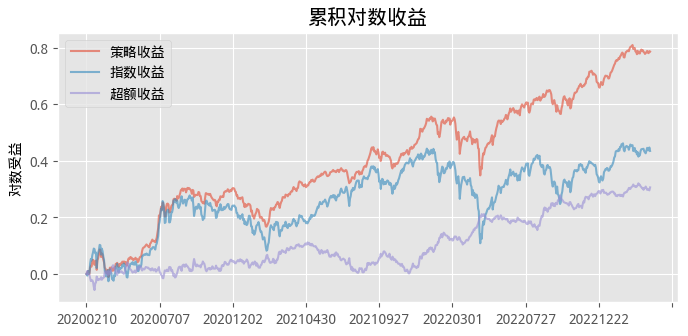

,指数收益,超额收益,策略收益
年化收益率,0.141,0.099,0.255
年化波动率,0.211,0.102,0.159
夏普率,0.669,0.978,1.603
最大回撤,-0.335,-0.110,-0.208
收益回撤比,0.422,0.907,1.228
胜率,0.541,0.519,0.577
盈亏比,0.949,1.083,0.970


In [43]:
h = ff.run((CTR_neu*ff.filter0).loc[:,'20200210':'20230413'], positions = 100, period = 1, fees = 0) 

## 4.2. 纯净换手率切割刀 CTR 因子
纯净因子分析

barra十因子的计算

EWMA:$v_t = β * v_{t-1} + (1 - β) * θ_t$

半衰期为 $ T $个交易日的指数加权移动平均权重计算公式为：

$ w_i = \exp\left(-\frac{\ln(2) \cdot i}{T}\right) $

其中，$w_i $是第 $i$ 个交易日的权重，半衰期为 $T$个交易日。


In [237]:
#1、size 市值因子：1*ln(cap);公司股票总市值的自然对数
total_mv=ff.read('total_mv')
factor_size=np.log(total_mv)

In [246]:
#2、bata 贝塔因子:1*beta;股票超额收益日序列和市值加权指数超额收益日序列的回归系数
# 半衰期为 63 个交易日
half_life = 63
# 计算权重
weights = np.exp(-np.log(2) * np.arange(252) / half_life)
# 归一化权重
weights /= weights.sum()
y_rt=(ff.read('close')*ff.read('post')).pct_change(1,axis=1)
# y_rtf无风险收益率，可以用一年期国债收益率代替
x_rt=pd.read_pickle('/mydata2/wangs/data/feature/zz1000.pk').loc[:,'close'].pct_change(1)

In [250]:
# 3、MOMENTUM（动量因子）
ff.read('turn20').dropna(how='all',axis=1)  #因子数据读取方式
# 剩下的难以计算

,20100702,20100705,20100706,20100707,20100708,20100709,20100712,20100713,20100714,20100715,...,20230908,20230911,20230912,20230913,20230914,20230915,20230918,20230919,20230920,20230921
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.673812,-1.687180,-1.679192,-1.677417,-1.682380,-1.609063,-1.595903,-1.567218,-1.558312,-1.545261
000002.SZ,-1.985096,-1.945201,-1.966365,-1.929865,-1.961303,-1.907279,-1.778854,-1.824959,-1.737446,-1.894317,...,-1.564953,-1.587404,-1.576231,-1.589017,-1.603180,-1.528943,-1.523895,-1.489814,-1.480276,-1.458378
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.834210,5.422383,5.250950,5.050401,4.810338,4.641945,4.543249,4.345237,4.008201,4.523118
000005.SZ,-1.698273,-1.687912,-1.737279,-1.701869,-1.736547,-1.682781,-1.642962,-1.722087,-1.620760,-1.579861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,-1.637848,-1.614561,-1.650404,-1.600339,-1.637991,-1.581150,-1.481397,-1.528892,-1.436782,-1.382713,...,4.654667,4.172676,3.728825,3.006485,2.515904,2.265367,2.060974,1.765403,1.531379,1.344046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873339.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873527.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873576.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873593.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
# 进行指数加权移动平均
weights = np.exp(np.linspace(-1, 0, 63))
weights /= weights.sum()
weights

array([0.00922552, 0.00937553, 0.00952797, 0.0096829 , 0.00984034,
       0.01000034, 0.01016294, 0.01032819, 0.01049613, 0.01066679,
       0.01084023, 0.01101649, 0.01119562, 0.01137766, 0.01156265,
       0.01175066, 0.01194172, 0.01213589, 0.01233322, 0.01253376,
       0.01273755, 0.01294466, 0.01315514, 0.01336904, 0.01358642,
       0.01380733, 0.01403184, 0.01425999, 0.01449186, 0.01472749,
       0.01496696, 0.01521032, 0.01545763, 0.01570897, 0.0159644 ,
       0.01622398, 0.01648777, 0.01675586, 0.01702831, 0.01730519,
       0.01758657, 0.01787252, 0.01816312, 0.01845845, 0.01875858,
       0.01906359, 0.01937356, 0.01968858, 0.02000871, 0.02033405,
       0.02066467, 0.02100068, 0.02134214, 0.02168916, 0.02204182,
       0.02240022, 0.02276444, 0.02313459, 0.02351075, 0.02389303,
       0.02428153, 0.02467634, 0.02507757])

## 4.3. CTR 因子的参数敏感性
改变回看天数为 40、60 个交易日，检验 CTR 因子的回测效果，并与 itaTurn20 因
子进行对比。

## 4.4. CTR 因子的多空收益拆解

## 4.5. 其他样本空间表现

# 5. 管中窥豹：切割法的有效性讨论

# 6. 殊途同归：抢跑 CTR 因子
日内换手率，按照次日隔夜聪明钱从低
到高排,取隔夜聪明钱最小的三天的换手率，加上本月最后一个交易日的日内换手率，
取这四天的换手率平均值后市值中性化得到新因子，抢跑 CTR（JumpCTR）。序

In [18]:
# 抢跑 CTR 因子
# 次日隔夜聪明钱对日内换手率做切割
# 把低次日隔夜聪明钱切割出的因子作为新因子
# 前一个交易日的日内换手率
t_rate_in_front=t_rate_in.shift(1,axis=1)# 昨日日内换手率
t_rate_open_nex=t_rate_open.shift(-1,axis=1)# 次日隔夜换手率
pct_chg_bt_nex=pct_chg_bt.shift(-1,axis=1)# 次日隔夜收益率
#如“行业、市值中性化”，一般指做回归：以市值或行业向量为解释变量，因子数据为被解释变量，使用最小二乘法，正交化后的残差成为中性化后的因子数据，这样的作法可以消除行业、市值对于股票因子数据的影响。
def get_JumpCTR(date):
    result={}
    n_date=t_rate.columns.tolist().index(date)
    # 筛选数据
    data_rate_in=t_rate_in.iloc[:,(n_date-20):n_date]#当前交易日的日内换手率
    data_open=t_rate_open_nex.iloc[:,(n_date-20):n_date]#次日隔夜换手率
    data_pct=pct_chg_bt_nex.iloc[:,(n_date-20):n_date]#次日隔夜收益率
    for code in t_rate.index:
        data=pd.concat([data_rate_in.loc[code,:],data_open.loc[code,:],data_pct.loc[code,:]],axis=1)
        data.columns=['data_rate_in','data_open',"data_pct"]
        last_t_rate_in=data.iloc[-1,0]
        pct_min=data["data_pct"].min()
        pct_max=data["data_pct"].max()
        data['OvernightSmart']=((data["data_pct"]-pct_min)/(pct_max-pct_min))/data['data_open']  # 次日隔夜聪明钱
        data=data.sort_values('OvernightSmart')
        result[code]=(data.iloc[0:3,0].sum()+last_t_rate_in)/4
    return result

In [19]:
with Pool(24) as p:
    res_lst_get_JumpCTR = list(tqdm(p.imap(get_JumpCTR, dates), total=len(dates)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [03:59<00:00,  3.22it/s]


In [20]:
JumpCTR_un=pd.DataFrame(data=res_lst_get_JumpCTR,index=dates).T

In [21]:
JumpCTR_un.loc['000001.SZ',:]

20200210    0.634202
20200211    0.690264
20200212    0.696231
20200213    0.655157
20200214    0.648505
              ...   
20230403    0.567845
20230404    0.551590
20230406    0.539494
20230407    0.530196
20230410    0.428903
Name: 000001.SZ, Length: 771, dtype: float64

In [47]:
JumpCTR_neu = extend.spread_reg(JumpCTR_un, mv.loc[JumpCTR_un.index,JumpCTR_un.columns],ind=False) # ind=True为同时进行市值与行业中性化

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


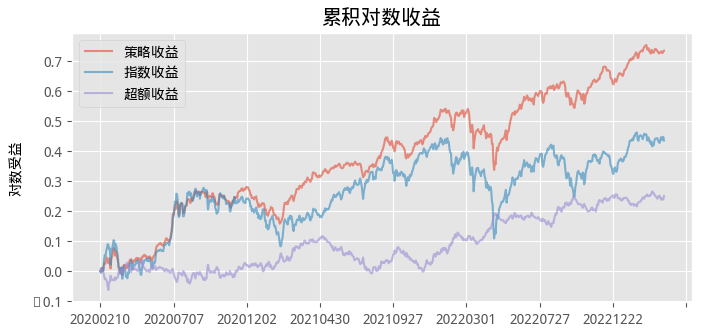

,指数收益,超额收益,策略收益
年化收益率,0.141,0.081,0.238
年化波动率,0.211,0.104,0.154
夏普率,0.669,0.785,1.541
最大回撤,-0.335,-0.124,-0.204
收益回撤比,0.422,0.656,1.167
胜率,0.541,0.497,0.584
盈亏比,0.949,1.147,0.935


In [48]:
h = ff.run((JumpCTR_neu*ff.filter0).loc[:,dates], positions = 100, period = 1, fees = 0) 

In [342]:
# 递归方程
def findRotateSteps(ring: str, key: str) -> int:
    left=[0]*len(key)
    right=[0]*len(key)
    def dfs(i,j):#从key的第i个开始，以及ring的第j个匹配12：00所需的最小步数；有dfs(0,0)就是我们想要的答案
        if i >= len(key):
            return 0
        else:
            for l in range(len(ring)):
                p=(j+l)%len(ring)
                if ring[p]==key[i]:
                    right=l
                    break
            for l in range(len(ring)):
                q=(j-l)%len(ring)
                if ring[j-l]==key[i]:
                    left=l
                    break
            return min(dfs(i+1,p)+right,dfs(i+1,q)+left)
    return dfs(0,0)+len(key)
                    

In [ ]:
[0]*len(key)